In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools

In [ ]:
G = nx.DiGraph() #define a directed graph
map_tasks = 10
reduce_tasks = 5

In [ ]:
G.add_nodes_from([i for i in range(map_tasks)]) #creates the map tasks
G.add_node(map_tasks) #barreir sync for map tasks
G.add_edges_from([(i,map_tasks) for i in range(map_tasks)])  #adding edges from map taskss to the sync node
G.add_nodes_from([i+map_tasks+1 for i in range(reduce_tasks)]) #create reduce tasks
G.add_edges_from([(map_tasks, i+map_tasks+1) for i in range(reduce_tasks)]) #add edges from the sync node to the reduce tasks
G.add_node(map_tasks+reduce_tasks+1) #final node to sync the reduce tasks
G.add_edges_from([(i+map_tasks+1, map_tasks+reduce_tasks+1) for i in range(reduce_tasks)]) #adding edges from reduce tasks to end sync node

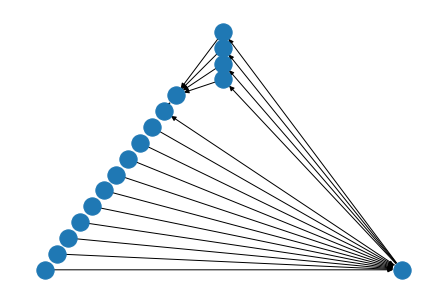

In [ ]:
nx.draw_planar(G)

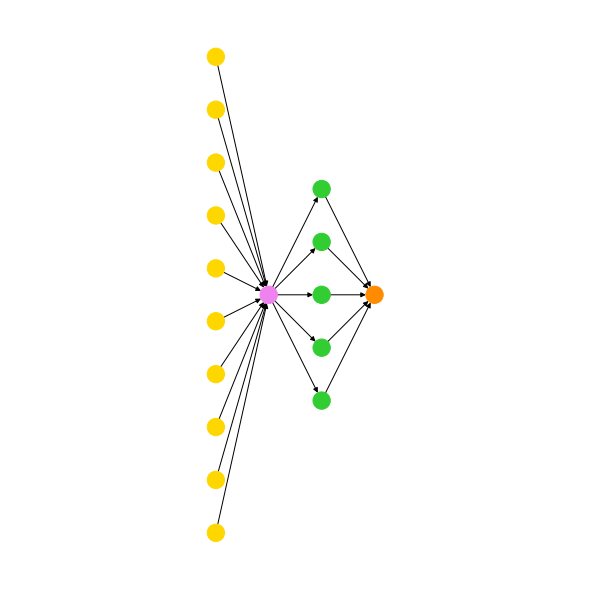

In [ ]:
subset_sizes = [map_tasks, 1, reduce_tasks, 1]
subset_color = [
    "gold",
    "violet",
    "limegreen",
    "darkorange",
]


def multilayered_graph(*subset_sizes):
    extents = nx.utils.pairwise(itertools.accumulate((0,) + subset_sizes))
    layers = [range(start, end) for start, end in extents]
    G = nx.DiGraph()
    for (i, layer) in enumerate(layers):
        G.add_nodes_from(layer, layer=i)
    for layer1, layer2 in nx.utils.pairwise(layers):
        G.add_edges_from(itertools.product(layer1, layer2))
    return G


G = multilayered_graph(*subset_sizes)
color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]
pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_color=color, with_labels=False)
plt.axis("equal")
plt.show()

In [ ]:
list(nx.topological_sort(G)) #for scheduling the tasks in the order

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [ ]:
len(G.in_edges(16, data=False)) #get the incoming edges to find the dependencies

5

In [ ]:
for k in (G[10].keys()): #get the out-edges of a task
  print(k)

11
12
13
14
15


In [ ]:
from enum import Enum
class EventType(Enum):
  TERMINATE = 1
  FAIL = 2
  STRAGGLE = 3

In [ ]:
class WorkerStatus(Enum):
  FREE = 1
  FAILED = 2
  BUSY = 3

In [ ]:
class TaskStatus(Enum):
  COMPLETE = 1
  PENDING = 2
  UNASIGGNED = 3

In [ ]:
class Event:
  def __init__(self, time =0, event_type:EventType = None, worker:Worker = None) -> None:
      self.time = time
      self.event_type = event_type 
      self.worker = worker

In [ ]:
class Task:
  def __init__(self, task_id, task_status:TaskStatus, task_dependencies=0) -> None:
      self.task_id = task_id
      self.status = task_status
      self.task_dependencies = task_dependencies

In [ ]:
from traitlets.traitlets import List
class Worker:
  def __init__(self, memory_size, network_bandwidth, disk_bandwidth, status:WorkerStatus, failure_rate, straggle_rate, task:Task = None) -> None:
      self.memory_size = memory_size
      self.network_bandwidth = network_bandwidth
      self.disk_bandwidth = disk_bandwidth
      self.status = status
      self.task = task
      self.failure_rate = failure_rate
      self.straggle_rate = straggle_rate

      def processing_time(self)->List[EventType,int]:
        #use task and worker parameters to figure out the procesing time for the worker
        return [EventType.TERMINATE, 20]
      

In [ ]:

from queue import Queue, PriorityQueue
class Scheduler:
  def __init__(self, G:nx.DiGraph, Workers) -> None:
    self.G = G
    self.Workers = Workers

  def simulate(self)->None:

      # choose a first task from the head of the queue
      # task is ready
      # hashmap of workers which stores the busy/free workers
      # assign task to the worker
      # create an event, some time units for the task insert the event in priority queue


    task_queue = Queue() #task queue as a topologically sorted task graph
    event_queue = PriorityQueue() #priority queue for events 
    free_worker_list = self.Workers #list to store the free workers
    

    #initiliaze the task dependency numbers
    for n in range(len( self.G.nodes)):
      G[n].task_dependencies = G.in_degree(n)
      if (G[n].task_dependencies == 0):
        task_queue.put(G[n]) #add the ready tasks to the queue

    while(task_queue.not_empty): #iterate through the tasks that are ready to execute
      task = task_queue.get() #get the first task from the queue
      if len(free_worker_list) == 0:
        break
      worker = free_worker_list.pop() #remove a worker from the free_list
      worker.task = task #assign the task to the worker
      worker.status = WorkerStatus.BUSY
      event_type, task_process_time = worker.processing_time() #get the approximate processing time and the probabilistic fate of the worker
      event = Event(task_process_time, event_type, worker) #create an event with the above parameters
      event_queue.put(event) #add the event to the event queue


    while(event_queue.not_empty):

      event = event_queue.get()
      if (event.event_type == EventType.TERMINATE):
        worker = event.worker
        worker.task.status = TaskStatus.COMPLETE
        for k in (G[worker.task.task_id].keys()): #get the out-edges of a task
          G[k].task_dependencies -= 1 #decrement the dependecies of all out_going edges
          if (G[k].task_dependencies == 0): #if dependencies of a task are 0, it is ready to be added into the task queue
            task_queue.put(G[k])
        worker.task = None #remove the task from the worker
        worker.status = WorkerStatus.FREE #mark the status of the worker to free
        free_worker_list.append(worker) #add the worker to the free list

    return None
    